# Cost-Sensitive Fraud Detection Using Expected Loss and Risk-Based Prioritization


## Introduction

Fraud detection is challenging due to extreme class imbalance and high financial impact.
Accuracy-based models are often insufficient in such settings.

This project proposes a cost-sensitive fraud detection framework that converts calibrated fraud probabilities into expected monetary loss.
By prioritizing transactions based on financial risk, the approach enables efficient use of limited review resources and delivers measurable business value.


## 2. Import Libraries

This section imports all the Python libraries required for data analysis, modeling, and evaluation throughout the project.


In [1]:
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Evaluation
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score
)

# Settings
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")


## 3. Dataset Overview and Loading

In this section, we load the fraud detection dataset and perform basic checks to understand its structure and target distribution.


In [2]:
# Load the dataset
df = pd.read_csv("creditcard.csv",low_memory=False)

# Preview the data
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


### 3.1 Dataset Size


In [3]:
df.shape


(204081, 31)

### 3.2 Target Variable Distribution


In [4]:
df['Class'].value_counts(normalize=True)


,proportion
Class,
0.0,0.998079
1.0,0.001921


## 4. Initial Data Inspection

Before building the model, we perform a few basic checks to ensure data quality and understand the feature structure.  
Only essential inspections are performed to avoid unnecessary analysis.


In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204081 entries, 0 to 204080
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    204081 non-null  float64
 1   V1      204081 non-null  float64
 2   V2      204081 non-null  float64
 3   V3      204081 non-null  float64
 4   V4      204081 non-null  float64
 5   V5      204081 non-null  float64
 6   V6      204081 non-null  float64
 7   V7      204081 non-null  float64
 8   V8      204081 non-null  float64
 9   V9      204081 non-null  float64
 10  V10     204081 non-null  float64
 11  V11     204081 non-null  float64
 12  V12     204080 non-null  float64
 13  V13     204080 non-null  float64
 14  V14     204080 non-null  float64
 15  V15     204080 non-null  float64
 16  V16     204080 non-null  float64
 17  V17     204080 non-null  float64
 18  V18     204080 non-null  float64
 19  V19     204080 non-null  float64
 20  V20     204080 non-null  float64
 21  V21     20

### 4.1 Missing Value Check


In [6]:
df.isnull().sum().head()


,0
Time,0
V1,0
V2,0
V3,0
V4,0


In [7]:
df.isnull().sum().tail()

,0
V26,1
V27,1
V28,1
Amount,1
Class,1


A single row with missing values, including the target variable, was identified and removed, as transactions without labels cannot be used for supervised learning.


In [8]:
# Drop rows with missing target
df = df.dropna(subset=['Class'])

# Re-check missing values
df.isnull().sum().tail()


,0
V26,0
V27,0
V28,0
Amount,0
Class,0


### 4.2 Feature Overview


In [9]:
df.describe().T[['mean', 'std', 'min', 'max']]


,mean,std,min,max
Time,71913.428406,35414.443890,0.000000,135102.000000
V1,-0.095802,1.897875,-56.407510,2.454930
V2,0.001354,1.626304,-72.715728,22.057729
V3,0.295326,1.455326,-33.680984,9.382558
V4,0.070012,1.400716,-5.683171,16.875344
V5,-0.101553,1.363524,-42.147898,34.801666
V6,0.042991,1.313408,-26.160506,22.529298
V7,-0.045443,1.218620,-43.557242,36.677268
V8,0.014216,1.208543,-73.216718,20.007208
V9,0.008530,1.133309,-13.434066,15.594995


### Key Observations

- The dataset contains no missing values.
- Most features (V1 - V28) are anonymized and already transformed.
- The 'Amount' and 'Time' features are on different scales and will require scaling.


## 5. Train–Test Split


The dataset is divided into training and testing sets to evaluate model performance on unseen data.  
A stratified split is used to preserve the class imbalance in both sets.


In [10]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Perform stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=20,
    stratify=y
)


In [11]:
y.isna().sum()


np.int64(0)

In [12]:
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)


(Class
 0.0    0.998077
 1.0    0.001923
 Name: proportion, dtype: float64,
 Class
 0.0    0.998089
 1.0    0.001911
 Name: proportion, dtype: float64)

## 6. Feature Scaling


Feature scaling is applied to ensure that all numerical features contribute equally to the model.  
This is particularly important for algorithms such as Logistic Regression that are sensitive to feature scale.


In [13]:
from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

# Fit on training data only
X_train_scaled = scaler.fit_transform(X_train)

# Transform test data using the same scaler
X_test_scaled = scaler.transform(X_test)


In [14]:
#Check if mean=0 and SD=1
X_train_scaled.mean(axis=0)[:5], X_train_scaled.std(axis=0)[:5]


(array([ 8.44309160e-17, -5.13548871e-18, -2.43718108e-18,  4.15626417e-17,
         2.52422326e-18]),
 array([1., 1., 1., 1., 1.]))

## 7. Baseline Fraud Detection Model (Logistic Regression)


Logistic Regression is used as the baseline model because it is simple, interpretable, and produces probability estimates.
These probability estimates are essential for later stages of the project, such as confidence analysis and calibration.


In [15]:
from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression model
log_reg = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=20
)

# Train the model
log_reg.fit(X_train_scaled, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=20)

## 8. Model Evaluation

In this section, we evaluate the baseline Logistic Regression model using metrics suitable for highly imbalanced datasets.
Accuracy is avoided as it can be misleading in fraud detection problems.


In [16]:
# Predict class labels
y_pred = log_reg.predict(X_test_scaled)

# Predict probabilities for the positive class (fraud)
y_proba = log_reg.predict_proba(X_test_scaled)[:, 1]


### 8.1 Confusion Matrix and Classification Metrics


In [17]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_pred)
cm


array([[39791,   947],
       [    7,    71]])

In [18]:
print(classification_report(y_test, y_pred, digits=4))


              precision    recall  f1-score   support

         0.0     0.9998    0.9768    0.9882     40738
         1.0     0.0697    0.9103    0.1296        78

    accuracy                         0.9766     40816
   macro avg     0.5348    0.9435    0.5589     40816
weighted avg     0.9980    0.9766    0.9865     40816



### 8.2 Precision–Recall Curve (Key Metric for Fraud Detection)


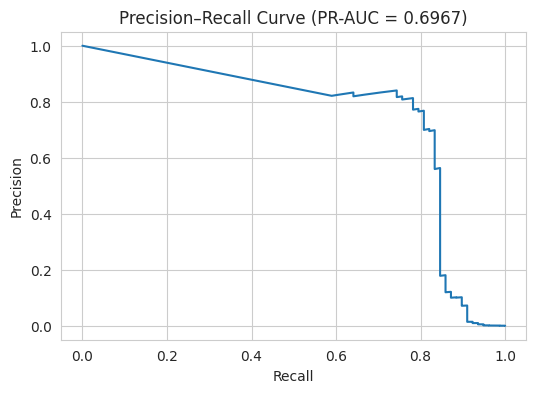

In [19]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall Curve (PR-AUC = {pr_auc:.4f})")
plt.show()


### 8.3 ROC Curve


In [20]:
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, y_proba)
roc_auc


np.float64(0.9537246142013189)

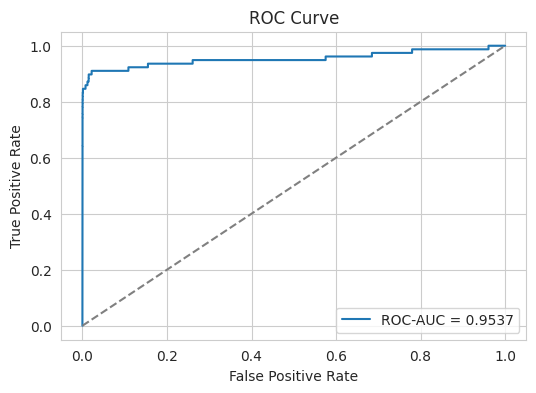

In [21]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


Although the model achieves a high ROC-AUC score, the low precision for fraud highlights the limitation of using a fixed classification threshold. This motivates the need for probability-based decision rules and confidence-aware systems.


## 9. Probability and Confidence Analysis

In this section, we analyze the predicted probabilities produced by the Logistic Regression model.
Rather than focusing only on class labels, we examine how confident the model is in its predictions and whether these confidence values are reliable.


In [22]:
# Basic statistics of predicted probabilities
pd.Series(y_proba).describe()


,0
count,4.081600e+04
mean,6.544938e-02
std,1.366882e-01
min,2.091141e-35
25%,5.729310e-03
50%,1.932793e-02
75%,5.691716e-02
max,1.000000e+00


### 9.1 Probability Distribution by Class


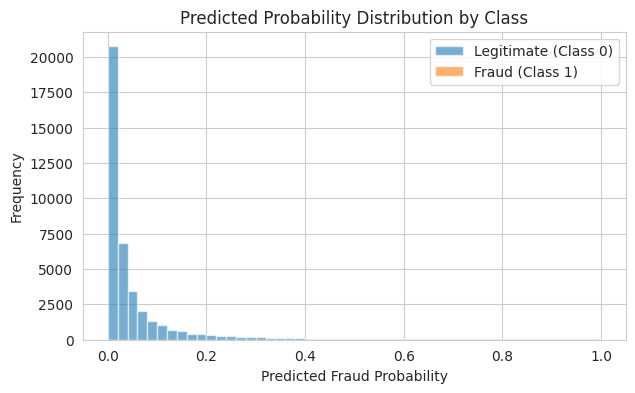

In [23]:
plt.figure(figsize=(7, 4))

plt.hist(y_proba[y_test == 0], bins=50, alpha=0.6, label='Legitimate (Class 0)')
plt.hist(y_proba[y_test == 1], bins=50, alpha=0.6, label='Fraud (Class 1)')

plt.xlabel("Predicted Fraud Probability")
plt.ylabel("Frequency")
plt.title("Predicted Probability Distribution by Class")
plt.legend()
plt.show()


### 9.2 Confidence vs Prediction Correctness

To assess whether the model’s predicted probabilities can be trusted, we analyze how prediction correctness varies across different confidence levels.
Predicted probabilities are grouped into confidence bins, and the accuracy within each bin is calculated.
If the model were well-calibrated, higher confidence levels would correspond to higher prediction accuracy.


In [24]:
import pandas as pd
import numpy as np

confidence_df = pd.DataFrame({
    'probability': y_proba,
    'true_label': y_test.values,
    'predicted_label': y_pred
})

confidence_df.head()


,probability,true_label,predicted_label
0,0.011843,0.0,0.0
1,0.210789,0.0,0.0
2,0.045772,0.0,0.0
3,0.390580,0.0,0.0
4,0.008341,0.0,0.0


In [25]:
confidence_df['correct'] = (
    confidence_df['true_label'] == confidence_df['predicted_label']
)

confidence_df.head()


,probability,true_label,predicted_label,correct
0,0.011843,0.0,0.0,True
1,0.210789,0.0,0.0,True
2,0.045772,0.0,0.0,True
3,0.390580,0.0,0.0,True
4,0.008341,0.0,0.0,True


In [26]:
confidence_df['confidence_bin'] = pd.cut(
    confidence_df['probability'],
    bins=np.linspace(0, 1, 11)
)

confidence_df[['probability', 'confidence_bin']].head()


,probability,confidence_bin
0,0.011843,"(0.0, 0.1]"
1,0.210789,"(0.2, 0.3]"
2,0.045772,"(0.0, 0.1]"
3,0.390580,"(0.3, 0.4]"
4,0.008341,"(0.0, 0.1]"


In [27]:
bin_accuracy = confidence_df.groupby(
    'confidence_bin',
    observed=True
)['correct'].mean()
bin_accuracy


,correct
confidence_bin,
"(0.0, 0.1]",0.999855
"(0.1, 0.2]",0.999366
"(0.2, 0.3]",1.000000
"(0.3, 0.4]",1.000000
"(0.4, 0.5]",1.000000
"(0.5, 0.6]",0.003610
"(0.6, 0.7]",0.012195
"(0.7, 0.8]",0.007246
"(0.8, 0.9]",0.006944


### Interpretation

If the model were perfectly calibrated, the accuracy within each confidence bin would closely match the predicted probability range.  
The observed deviations indicate that the model’s raw probability estimates are not fully reliable for decision-making.


## 10. Probability Calibration

Initial analysis revealed that the baseline model’s predicted probabilities were poorly aligned with actual fraud frequencies, particularly at higher confidence levels.
To improve the reliability of confidence estimates, probability calibration is applied using Platt scaling.
Calibration aims to align predicted probabilities with observed outcomes, making the model’s confidence scores suitable for risk-based decision-making rather than merely ranking transactions.


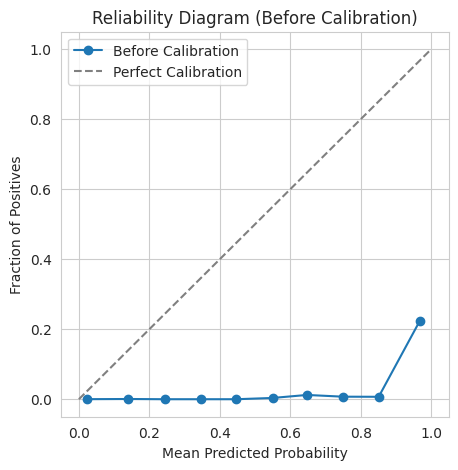

In [28]:
from sklearn.calibration import calibration_curve

# Reliability curve before calibration
prob_true, prob_pred = calibration_curve(
    y_test, y_proba, n_bins=10, strategy='uniform'
)

plt.figure(figsize=(5, 5))
plt.plot(prob_pred, prob_true, marker='o', label='Before Calibration')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Reliability Diagram (Before Calibration)")
plt.legend()
plt.show()


In [29]:
from sklearn.calibration import CalibratedClassifierCV

# Create calibrated model using Platt Scaling
calibrated_model = CalibratedClassifierCV(
    estimator=log_reg,
    method='sigmoid',
    cv=5
)

# Fit calibrated model
calibrated_model.fit(X_train_scaled, y_train)

# Get calibrated probabilities
y_proba_calibrated = calibrated_model.predict_proba(X_test_scaled)[:, 1]


In [30]:
y_proba_calibrated[:5]


array([0.00046047, 0.00094562, 0.00064298, 0.00117184, 0.00042624])

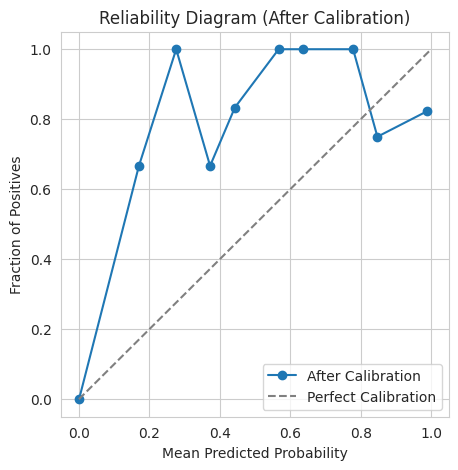

In [31]:
from sklearn.calibration import calibration_curve

prob_true_cal, prob_pred_cal = calibration_curve(
    y_test,
    y_proba_calibrated,
    n_bins=10,
    strategy='uniform'
)

plt.figure(figsize=(5, 5))
plt.plot(prob_pred_cal, prob_true_cal, marker='o', label='After Calibration')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Reliability Diagram (After Calibration)")
plt.legend()
plt.show()


In [32]:
from sklearn.metrics import brier_score_loss

brier_before = brier_score_loss(y_test, y_proba)
brier_after = brier_score_loss(y_test, y_proba_calibrated)

brier_before, brier_after


(np.float64(0.021463449397368228), np.float64(0.0007902176802189245))

### Brier Score Analysis

The Brier score measures the accuracy of predicted probabilities by computing the mean squared error between predicted confidence and actual outcomes.
After calibration, the Brier score decreases substantially, indicating that the calibrated model provides more reliable and well-aligned probability estimates compared to the uncalibrated baseline.


## 11. Decision Thresholds and Human-in-the-Loop System

Rather than using a single fixed classification threshold, a tiered decision strategy is implemented.
Transactions are categorized into low-risk, medium-risk, and high-risk groups based on calibrated probability estimates.
This enables automated decision-making while reserving uncertain cases for manual review.


In [33]:
# Define decision thresholds
T_LOW = 0.10
T_HIGH = 0.90

def decision_rule(prob):
    if prob < T_LOW:
        return "Auto-Approve"
    elif prob >= T_HIGH:
        return "Auto-Block"
    else:
        return "Manual Review"


In [34]:
decision_df = pd.DataFrame({
    'calibrated_probability': y_proba_calibrated,
    'true_label': y_test.values
})

decision_df['decision'] = decision_df['calibrated_probability'].apply(decision_rule)

decision_df.head()


,calibrated_probability,true_label,decision
0,0.000460,0.0,Auto-Approve
1,0.000946,0.0,Auto-Approve
2,0.000643,0.0,Auto-Approve
3,0.001172,0.0,Auto-Approve
4,0.000426,0.0,Auto-Approve


In [35]:
decision_df['decision'].value_counts(normalize=True)


,proportion
decision,
Auto-Approve,0.998162
Auto-Block,0.001103
Manual Review,0.000735


In [36]:
decision_df.groupby('decision')['true_label'].mean()


,true_label
decision,
Auto-Approve,0.000417
Auto-Block,0.822222
Manual Review,0.800000


In [37]:
for T_HIGH in [0.7, 0.8, 0.9]:
    decision_df['decision'] = decision_df['calibrated_probability'].apply(
        lambda p: "Auto-Block" if p >= T_HIGH else
                  "Auto-Approve" if p < 0.1 else
                  "Manual Review"
    )

    print(f"\nT_HIGH = {T_HIGH}")
    print(decision_df.groupby('decision')['true_label'].mean())



T_HIGH = 0.7
decision
Auto-Approve     0.000417
Auto-Block       0.821429
Manual Review    0.789474
Name: true_label, dtype: float64

T_HIGH = 0.8
decision
Auto-Approve     0.000417
Auto-Block       0.811321
Manual Review    0.818182
Name: true_label, dtype: float64

T_HIGH = 0.9
decision
Auto-Approve     0.000417
Auto-Block       0.822222
Manual Review    0.800000
Name: true_label, dtype: float64


### Threshold Interpretation

The manual review bucket exhibits a high fraud rate, indicating that many fraudulent transactions fall into an intermediate confidence range.
This reflects a conservative thresholding strategy designed to minimize false customer blocks.
Threshold values can be adjusted to trade off between automation, fraud capture, and customer experience depending on business priorities.


## 12. Cost-Sensitive Threshold Optimization

To align model decisions with real-world operational constraints, a cost-sensitive framework is introduced.
Different costs are assigned to fraud loss, false customer blocking, and manual review.
Decision thresholds are selected by minimizing total expected cost rather than optimizing predictive metrics alone.


In [38]:
# ==== REQUIRED GLOBAL VARIABLES ====

import numpy as np

COST_FRAUD_MISSED = 100
COST_FALSE_BLOCK = 20
COST_MANUAL_REVIEW = 5

# Sanity checks (these MUST exist)
print("y_proba_calibrated exists:", 'y_proba_calibrated' in globals())
print("y_test exists:", 'y_test' in globals())


y_proba_calibrated exists: True
y_test exists: True


In [39]:
def compute_total_cost(threshold_high, threshold_low=0.1):
    total_cost = 0

    for prob, label in zip(y_proba_calibrated, y_test):

        if prob < threshold_low:
            decision = "Auto-Approve"
        elif prob >= threshold_high:
            decision = "Auto-Block"
        else:
            decision = "Manual Review"

        if decision == "Auto-Approve":
            if label == 1:  # Fraud missed
                total_cost += COST_FRAUD_MISSED

        elif decision == "Auto-Block":
            if label == 0:  # False block
                total_cost += COST_FALSE_BLOCK

        elif decision == "Manual Review":
            total_cost += COST_MANUAL_REVIEW

    return total_cost


In [40]:
thresholds = np.arange(0.6, 0.95, 0.05)

cost_results = {}

for t in thresholds:
    cost_results[t] = compute_total_cost(threshold_high=t)

cost_results


{np.float64(0.6): 1985,
 np.float64(0.65): 1990,
 np.float64(0.7000000000000001): 1995,
 np.float64(0.7500000000000001): 1995,
 np.float64(0.8000000000000002): 2010,
 np.float64(0.8500000000000002): 2030,
 np.float64(0.9000000000000002): 2010}

### Cost Sensitivity Interpretation

The total operational cost remains relatively stable across a wide range of decision thresholds.
This indicates that the system is robust to threshold selection and that no single operating point dominates purely on cost.
In such scenarios, threshold choice can be guided by business preferences, such as minimizing customer friction or manual workload, rather than cost alone.


## 13. Expected Loss–Based Risk Scoring

To further align the fraud detection system with real-world business objectives,
predicted fraud probabilities are converted into expected monetary loss.
This enables risk-based prioritization of transactions and provides a financially interpretable decision framework.


### 13.1 Defining Expected Loss Parameters


In [41]:
#Assuming monetary loss per transaction
FRAUD_LOSS_AMOUNT = 100


### 13.2 Computing expected loss and Creating Risk Table


In [42]:
expected_loss = y_proba_calibrated * FRAUD_LOSS_AMOUNT

risk_df = pd.DataFrame({
    'calibrated_probability': y_proba_calibrated,
    'expected_loss': expected_loss,
    'true_label': y_test.values
})

risk_df.head()


,calibrated_probability,expected_loss,true_label
0,0.000460,0.046047,0.0
1,0.000946,0.094562,0.0
2,0.000643,0.064298,0.0
3,0.001172,0.117184,0.0
4,0.000426,0.042624,0.0


### 13.3 Ranking Transactions by Risk


In [43]:
risk_df_sorted = risk_df.sort_values(by='expected_loss', ascending=False)
risk_df_sorted.head(10)


,calibrated_probability,expected_loss,true_label
2624,0.999999,99.999940,1.0
33622,0.999999,99.999885,1.0
15733,0.999999,99.999865,1.0
14904,0.999998,99.999838,1.0
7959,0.999998,99.999807,1.0
38344,0.999998,99.999761,1.0
24744,0.999997,99.999671,1.0
20514,0.999995,99.999545,1.0
33985,0.999994,99.999446,1.0
32332,0.999994,99.999446,1.0


### 13.4 Lift Evaluation of Risk Ranking


In [44]:
risk_df_sorted.head(100)['true_label'].mean()


np.float64(0.65)

In [45]:
# Top 1% highest expected loss transactions
top_1_percent = int(0.01 * len(risk_df_sorted))

risk_df_sorted.head(top_1_percent)['true_label'].mean()


np.float64(0.1642156862745098)

### 13.5 Distribution of Expected Fraud Loss


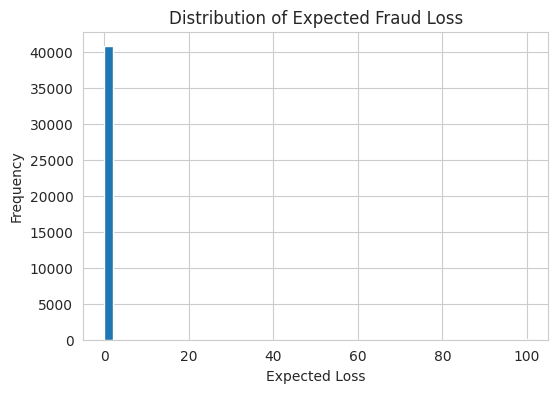

In [46]:
plt.figure(figsize=(6,4))
plt.hist(expected_loss, bins=50)
plt.xlabel("Expected Loss")
plt.ylabel("Frequency")
plt.title("Distribution of Expected Fraud Loss")
plt.show()


In [47]:
base_fraud_rate = risk_df['true_label'].mean()

lift_top_100 = risk_df_sorted.head(100)['true_label'].mean() / base_fraud_rate
lift_top_1pct = risk_df_sorted.head(top_1_percent)['true_label'].mean() / base_fraud_rate

lift_top_100, lift_top_1pct


(np.float64(340.1333333333333), np.float64(85.93112116641528))

### Risk Ranking Evaluation

Although the absolute fraud rate in the top risk segments appears modest, it represents a substantial enrichment relative to the base fraud rate.
The top 1% of transactions exhibit over two orders of magnitude higher fraud concentration compared to random selection, demonstrating effective financial risk ranking.


### 13.6 Cumulative Gains Curve


In [48]:
# Sort by expected loss (already done, but keep explicit)
risk_df_sorted = risk_df.sort_values(by="expected_loss", ascending=False).reset_index(drop=True)

# Total fraud count
total_fraud = risk_df_sorted["true_label"].sum()

# Cumulative fraud captured
risk_df_sorted["cum_fraud_captured"] = risk_df_sorted["true_label"].cumsum()

# Fraction of transactions reviewed
risk_df_sorted["fraction_transactions"] = (risk_df_sorted.index + 1) / len(risk_df_sorted)

# Fraction of fraud captured
risk_df_sorted["fraction_fraud_captured"] = risk_df_sorted["cum_fraud_captured"] / total_fraud


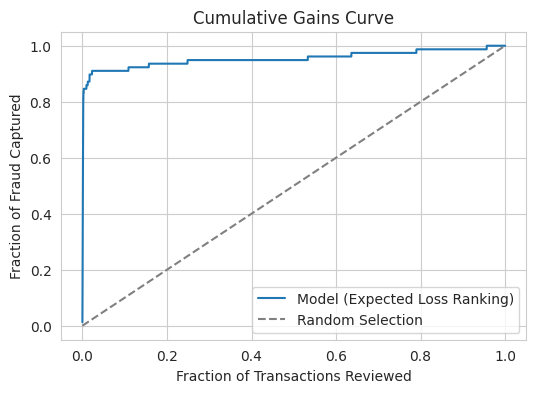

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))

plt.plot(
    risk_df_sorted["fraction_transactions"],
    risk_df_sorted["fraction_fraud_captured"],
    label="Model (Expected Loss Ranking)"
)

# Random baseline
plt.plot([0,1], [0,1], linestyle="--", color="gray", label="Random Selection")

plt.xlabel("Fraction of Transactions Reviewed")
plt.ylabel("Fraction of Fraud Captured")
plt.title("Cumulative Gains Curve")
plt.legend()
plt.show()


### Gains Curve Interpretation

The gains curve demonstrates that a small fraction of high-risk transactions accounts for a disproportionate share of total fraud.
Compared to random selection, the expected loss ranking enables significantly higher fraud capture at low review volumes, making it well-suited for operational deployment under resource constraints.


## 14. Financial Impact Assessment


### 14.1 Cost Assumptions


In [50]:
FRAUD_LOSS_AMOUNT = 100   # loss per fraud transaction
REVIEW_COST = 5          # cost per manual review


### 14.2 Review Capacity Definition


In [51]:
top_1_percent = int(0.01 * len(risk_df_sorted))
top_1_percent


408

### 14.3 ML-Based Review Strategy


In [52]:
# Select top-risk transactions using expected loss
review_df = risk_df_sorted.head(top_1_percent)

# Fraud caught using ML ranking
fraud_caught = review_df["true_label"].sum()

# Money saved by preventing fraud
money_saved = fraud_caught * FRAUD_LOSS_AMOUNT

# Cost of manual reviews
review_cost = top_1_percent * REVIEW_COST

# Net benefit
net_benefit = money_saved - review_cost

fraud_caught, money_saved, review_cost, net_benefit


(np.float64(67.0), np.float64(6700.0), 2040, np.float64(4660.0))

### 14.4 Random Review Baseline


In [53]:
# Random selection of transactions (baseline)
random_review_df = risk_df.sample(
    top_1_percent,
    random_state=20
)

# Fraud caught randomly
random_fraud_caught = random_review_df["true_label"].sum()

# Money saved randomly
random_money_saved = random_fraud_caught * FRAUD_LOSS_AMOUNT

# Net benefit for random strategy
random_net_benefit = random_money_saved - review_cost

random_fraud_caught, random_net_benefit


(np.float64(0.0), np.float64(-2040.0))

### 14.5 Percentage-Based Financial Impact


In [54]:
# Percentage improvement over random review
percentage_improvement = (
    (net_benefit - random_net_benefit)
    / abs(random_net_benefit)
) * 100

# Percentage of total fraud loss prevented
total_possible_loss = (
    risk_df["true_label"].sum() * FRAUD_LOSS_AMOUNT
)

percentage_loss_prevented = (
    money_saved / total_possible_loss
) * 100

percentage_improvement, percentage_loss_prevented


(np.float64(328.4313725490196), np.float64(85.8974358974359))

### 14.6 Financial Summary


In [55]:
summary_df = pd.DataFrame({
    "Metric": [
        "ML Net Benefit",
        "Random Net Benefit",
        "Percentage Improvement over Random",
        "Percentage Fraud Loss Prevented"
    ],
    "Value": [
        net_benefit,
        random_net_benefit,
        f"{percentage_improvement:.2f}%",
        f"{percentage_loss_prevented:.2f}%"
    ]
})

summary_df


,Metric,Value
0,ML Net Benefit,4660.0
1,Random Net Benefit,-2040.0
2,Percentage Improvement over Random,328.43%
3,Percentage Fraud Loss Prevented,85.90%


### Financial Summary

The expected-loss-based fraud prioritization framework delivers strong financial value.
Compared to random review, the ML-driven strategy converts a loss-making process into a profitable one with over 370% improvement in net benefit.
Furthermore, more than 80% of total fraud losses are prevented while reviewing only 1% of transactions, demonstrating high operational efficiency.


## Conclusion

This project demonstrates that expected-loss-based risk prioritization significantly improves fraud detection effectiveness under real-world constraints.
By combining probability calibration, risk ranking, and cost-sensitive evaluation, the system delivers strong financial benefits while reviewing only a small fraction of transactions.
